In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
import math


In [2]:
def find_similar(points):
    similar = []
    for j,point_j in enumerate(points.T):
        similar_j = []
        for i,point_i in enumerate(points.T):
            if (math.isclose(point_i[3], point_j[3],rel_tol = 1e-6)):
                if i != j:
                    similar_j.append(i)
        similar.append(similar_j)
    return similar
                    

In [3]:
def find_most_similar(points):
    # find the 3 mosgt similar points out of the set 
    distance_array = []
    for i in range(0,points.shape[0]):
        for j in range(i+1,points.shape[0]):
            distance_array.append([i,j,np.abs((points[i,3]-points[j,3])/(max(points[i,3],points[j,3])))])
    return  distance_array , np.argsort(np.asarray(distance_array)[:,2])


In [4]:
def find_one_similar(points):
    for j,point_j in enumerate(points.T):
        similar = []
        for i,point_i in enumerate(points.T):
            if (math.isclose(point_i[3], point_j[3],rel_tol = 1e-3)):
                if i != j:
                    similar.append(i)
        if len(similar) >= 3:
            return similar
    print("no large enough set of similar points found")
    return []
            


In [5]:

def rotation_matrix_arbitrary_axis(axis, angle):
    """
    Returns a 3D rotation matrix for rotating around an arbitrary axis by a given angle (in radians).
    
    :param axis: A 3D unit vector representing the axis of rotation (array-like or list).
    :param angle: The angle in radians by which to rotate.
    :return: A 3x3 rotation matrix.
    """
    axis = np.array(axis)
    axis = axis / np.linalg.norm(axis)  # Ensure the axis is a unit vector
    
    cos_theta = np.cos(angle)
    sin_theta = np.sin(angle)
    one_minus_cos = 1 - cos_theta
    
    # Skew-symmetric matrix of the axis
    K = np.array([
        [0, -axis[2], axis[1]],
        [axis[2], 0, -axis[0]],
        [-axis[1], axis[0], 0]
    ])
    
    # Outer product of the axis
    outer_product = np.outer(axis, axis)
    
    # Rotation matrix using Rodrigues' formula
    R = cos_theta * np.eye(3) + one_minus_cos * outer_product + sin_theta * K
    
    return R

def rotate_vector_arbitrary_axis(vector, axis, angle):
    """
    Rotates a 3D vector around an arbitrary axis by a given angle (in radians).
    
    :param vector: A 3D vector to rotate (as a list or numpy array).
    :param axis: A 3D unit vector representing the axis of rotation.
    :param angle: The angle in radians by which to rotate the vector.
    :return: The rotated 3D vector.
    """
    rot_matrix = rotation_matrix_arbitrary_axis(axis, angle)
    rotated_vector = np.dot(rot_matrix, vector)
    return rotated_vector

In [6]:
# dont role dice too often
import random

r_axis = np.asarray([np.float32(random.uniform(0,1)), np.float32(random.uniform(0,1)), np.float32(random.uniform(0,1))])
# r_axis = np.asarray([1,0,0])
r_angle = random.uniform(0,2*np.pi)
r_angle = np.pi/2
rot_mat = rotation_matrix_arbitrary_axis(r_axis, r_angle)

In [7]:
print(r_axis, r_angle)
# pretty: [0.30823973 0.17037524 0.06697026] 1.5707963267948966
# horrific example with mirror plane [0.63047713 0.05455516 0.3520908 ] 1.5707963267948966
#, optically the second one needs to be inverted

[0.22698711 0.93375534 0.6345456 ] 1.5707963267948966


In [8]:
# Ball:
# rotate pointset
cm = plt.get_cmap("RdYlGn")


res = 25

# Make data
phis = np.linspace(1e-1, np.pi/2-1e-1, res)
thetas = np.linspace(1e-1, np.pi/2-1e-1, res)
x,y,z,ref = np.empty((0)), np.empty((0)),np.empty((0)), np.empty((0))

for phi in phis:
    for theta in thetas:
        x =  np.append(x,np.cos(phi)*np.sin(theta))
        y =  np.append(y,np.sin(phi)*np.sin(theta))
        z =  np.append(z,np.cos(theta))
        ref = np.append(ref,abs(np.cos(theta)))

# rotate and stack the points
points = np.vstack((np.vstack((x,y)),z))

ref_grid = np.vstack((points,ref))

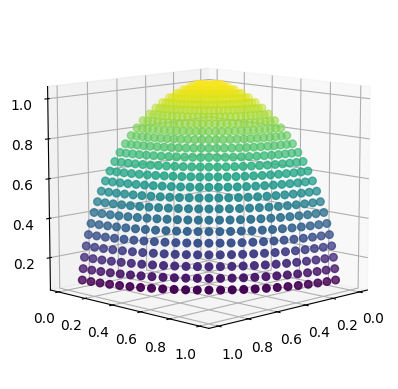

In [9]:

# 3D Plot
fig = plt.figure()
ax3D = fig.add_subplot(111, projection='3d')
p3d = ax3D.scatter(ref_grid[0,:], ref_grid[1,:], ref_grid[2,:], s=30, c=ref_grid[3,:], marker='o')                                                                                
ax3D.set_aspect('equal')
ax3D.view_init(elev=10., azim=45)

plt.show() 

In [10]:
col = np.empty((0))
for point in points.T:
        col = np.append(col,np.abs((rot_mat@np.array((0,0,1)))@point))
        # np.append(col,np.abs( point[2]))

# now stack
grid = np.vstack((points,col))



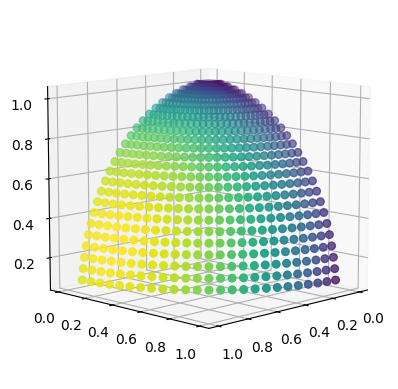

In [11]:
cutoff = points.shape[1]

# 3D Plot
fig = plt.figure()
ax3D = fig.add_subplot(111, projection='3d')
p3d = ax3D.scatter(grid[0,:cutoff], grid[1,:cutoff], grid[2,:cutoff], s=30, c=grid[3,:cutoff], marker='o')                                                                                
ax3D.set_aspect('equal')
ax3D.view_init(elev=10., azim=45)


plt.show() 

In [12]:
# f = open("grid.txt", "a")

# with open("grid.txt", "w") as f:
#     for point in grid.T:
#         print(*point, sep = ' ', file=f)
# with open("longitudinal.txt", "w") as f:
#     for point in longitudinal:
#         print(*point, sep = ' ', file=f)

In [13]:
# for i,similar in enumerate(similar_points):
#     print(i, similar)
dists, indices = find_most_similar(grid.T)
sorted_distances = np.asarray(dists)[indices,:]


In [14]:
def search_closets_thruple(sorted_distances):
        pairs, codons  = [], []
        for pair in sorted_distances:
            current_pair = [int(pair[0]), int(pair[1])]
            if current_pair[0] in pairs:
                # print(pairs.index(int(current_pair[0])))
                return current_pair[0], current_pair[1], codons[pairs.index(int(current_pair[0]))]
            if current_pair[1] in pairs:        
                return current_pair[0], current_pair[1], codons[pairs.index(int(current_pair[1]))]
                # print(pairs.index(int(current_pair[1])))        
            # print(current_pair[0] in [x for xs in pairs for x in xs], current_pair[1] in [x for xs in pairs for x in xs])
            print(current_pair, pairs, current_pair[0] in pairs, current_pair[1] in pairs)
            pairs.append(current_pair[0])
            pairs.append(current_pair[1])
            codons.append(current_pair[1])
            codons.append(current_pair[0])
    


In [15]:
thruple = search_closets_thruple(sorted_distances)
print(sorted_distances.shape)
print(thruple)

[255, 515] [] False False
[61, 212] [255, 515] False False
[523, 541] [255, 515, 61, 212] False False
[141, 174] [255, 515, 61, 212, 523, 541] False False
[92, 148] [255, 515, 61, 212, 523, 541, 141, 174] False False
[151, 555] [255, 515, 61, 212, 523, 541, 141, 174, 92, 148] False False
[105, 461] [255, 515, 61, 212, 523, 541, 141, 174, 92, 148, 151, 555] False False
[188, 292] [255, 515, 61, 212, 523, 541, 141, 174, 92, 148, 151, 555, 105, 461] False False
[306, 497] [255, 515, 61, 212, 523, 541, 141, 174, 92, 148, 151, 555, 105, 461, 188, 292] False False
[49, 194] [255, 515, 61, 212, 523, 541, 141, 174, 92, 148, 151, 555, 105, 461, 188, 292, 306, 497] False False
[437, 465] [255, 515, 61, 212, 523, 541, 141, 174, 92, 148, 151, 555, 105, 461, 188, 292, 306, 497, 49, 194] False False
[32, 258] [255, 515, 61, 212, 523, 541, 141, 174, 92, 148, 151, 555, 105, 461, 188, 292, 306, 497, 49, 194, 437, 465] False False
[134, 393] [255, 515, 61, 212, 523, 541, 141, 174, 92, 148, 151, 555, 105

In [16]:
longitudinal = []
for i in thruple:
    longitudinal.append(grid.T[i,:])

longitudinal = np.asarray(longitudinal)

In [17]:
# longitudinal[1,:] = -longitudinal[1,:]

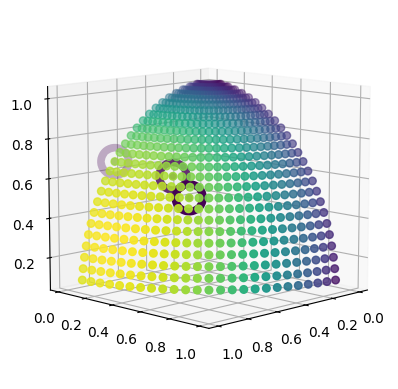

In [18]:
# 3D Plot
fig = plt.figure()
ax3D = fig.add_subplot(111, projection='3d')
ax3D.set_axisbelow(True)
p3d = ax3D.scatter(grid[0,:cutoff], grid[1,:cutoff], grid[2,:cutoff], s=30, c=grid[3,:cutoff], marker='o',zorder=-99)                                                                                
p3d = ax3D.scatter(longitudinal[:,0], longitudinal[:,1], longitudinal[:,2], s=30, c=longitudinal[:,3]*0, linewidths=20,  marker='o',zorder=2+2.5)                                                                                
ax3D.set_aspect('equal')
ax3D.view_init(elev=10., azim=45)

plt.show()  

In [19]:
a = longitudinal[0,:-1]
b = longitudinal[1,:-1]
c = longitudinal[2,:-1]


n = np.cross(a-c,b-a)
n = n/np.linalg.norm(n)
n_zn = np.cross(n,np.asarray([0,0,1]))
alpha = np.arccos(np.dot(n,np.asarray([0,0,1]))/(np.linalg.norm(n)))

print(f"n x (a-c)   : {n@(a-c)/(np.linalg.norm(a-c))}")
print(f"normalvector: {n/np.linalg.norm(n)}")
print(f"rotmat@z    : {rot_mat@np.asarray([0,0,1])}")
print(f"alpha       : {alpha}")


rot_mat_2 = rotation_matrix_arbitrary_axis(n_zn, np.arccos(np.dot(n,np.asarray([0,0,1]))/(np.linalg.norm(n))))
resulting_points = rot_mat_2@points[:,:]

print(rot_mat@rot_mat_2)

col_2 = np.empty((0))
for resulting_point in resulting_points.T:
        col_2 = np.append(col_2,np.abs( resulting_point[2]))

resulting_grid = np.vstack((resulting_points,col))
resulting_grid = np.vstack((resulting_grid,col_2))


n x (a-c)   : -1.445574229839734e-17
normalvector: [-0.91882431 -0.25000485 -0.30538413]
rotmat@z    : [0.91948429 0.24970251 0.30364016]
alpha       : 1.881138132743002
[[-0.72384267 -0.5987258  -0.34289832]
 [-0.59999415  0.30083035  0.74128819]
 [-0.34067415  0.74231297 -0.57698581]]


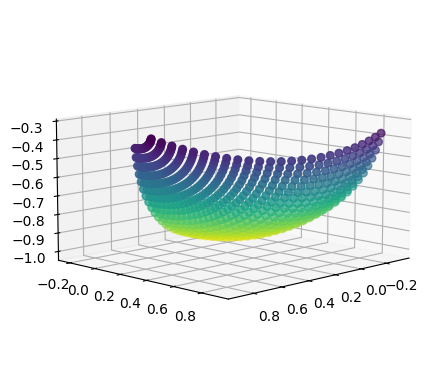

In [20]:
# 3D Plot
fig = plt.figure()
ax3D = fig.add_subplot(111, projection='3d')
ax3D.set_axisbelow(True)
p3d = ax3D.scatter(resulting_grid[0,:cutoff], resulting_grid[1,:cutoff], resulting_grid[2,:cutoff], s=30, c=resulting_grid[3,:cutoff], marker='o',zorder=-99)                                                                                
# p3d = ax3D.scatter(longitudinal[:,0], longitudinal[:,1], longitudinal[:,2], s=30, c=longitudinal[:,3]*0, linewidths=20,  marker='o',zorder=2+2.5)                                                                                
ax3D.set_aspect('equal')
ax3D.view_init(elev=10., azim=45)

plt.show()  

This is the result of the algorithm. If the orientation of the rotation has been found, the wedge is rotated in such a way that the longitudinals, i.e. the colorfull bands apper where we initially saw them in our reference figure, the first image of this notebook.

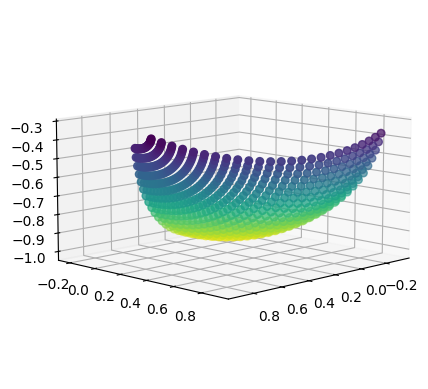

In [21]:
# 3D Plot
fig = plt.figure()
ax3D = fig.add_subplot(111, projection='3d')
ax3D.set_axisbelow(True)
p3d = ax3D.scatter(resulting_grid[0,:cutoff], resulting_grid[1,:cutoff], resulting_grid[2,:cutoff], s=30, c=resulting_grid[4,:cutoff], marker='o',zorder=-99)                                                                                
ax3D.set_aspect('equal')
ax3D.view_init(elev=10., azim=45)

plt.show()  

This image is just here to be compare to the previous image. it is the same set of coordinates, but instead of keeping the functional values we had evaluated before, we now just calculate exactly the z value. If the algorithm worked the figures are identical.

In [22]:
def get_k1(a,b,c,k_2):
    d = a-c
    e = b-c
    return (- (2*c@d + 2*e@d*k_2) + np.sqrt((2*c@d+2*e@d*k_2)**2 -4*d@d*(c@c+e@e*k_2**2-1+2*e@c*k_2)))/(2*d@d),  (- (2*c@d + 2*e@d*k_2) - np.sqrt((2*c@d+2*e@d*k_2)**2 -4*d@d*(c@c+e@e*k_2**2-1+2*e@c*k_2)))/(2*d@d)

In [23]:
def get_plane_circle(a,b,c):
    circle = np.zeros((3,2*20))
    d = a-c
    e = b-c
    i = 0
    for k_2 in np.linspace(0,1,20):
        k_1_p, k_1_m =  get_k1(a,b,c,k_2)
        circle[:,i] = c + k_1_p*d + k_2*e
        circle[:,20+i] = c + k_1_m*d + k_2*e
        i+=1
    return circle 

In [24]:
circle = get_plane_circle(a,b,c)
col_3 = np.empty((0))
for point in circle.T:
    # print(np.linalg.norm(point), point)
    col_3 = np.append(col_3,np.abs((rot_mat@np.array((0,0,1)))@point))
circle = np.vstack((circle,col_3))
circle = circle.T

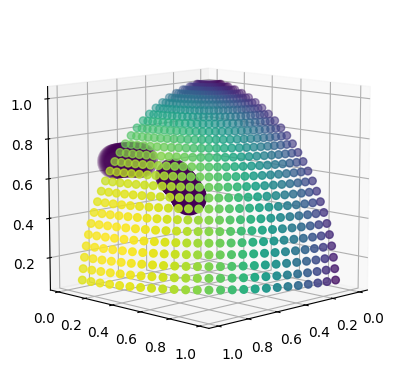

In [25]:
# 3D Plot
fig = plt.figure()
ax3D = fig.add_subplot(111, projection='3d')
ax3D.set_axisbelow(True)
p3d = ax3D.scatter(grid[0,:cutoff], grid[1,:cutoff], grid[2,:cutoff], s=30, c=grid[3,:cutoff], marker='o',zorder=-99)                                                                                
p3d = ax3D.scatter(circle[:,0], circle[:,1], circle[:,2], s=30, c=circle[:,3]*0, linewidths=20,  marker='o',zorder=2+2.5)                                                                                
ax3D.set_aspect('equal')
ax3D.view_init(elev=10., azim=45)

plt.show()  

In [26]:
with open("grid.txt", "w") as f:
    for point in grid.T:
        print(*point, sep = ' ', file=f)
with open("longitudinal.txt", "w") as f:
    for point in longitudinal:
        print(*point, sep = ' ', file=f)
with open("circle.txt", "w") as f:
    for point in circle:
        print(*point, sep = ' ', file=f)

Initial circle test, if it worked, the points on the circle are very similar, the two inversio attempts then have to fail.

In [37]:
# check if circle is fine 
print(longitudinal[0], longitudinal[1], longitudinal[2])
print(circle[0], circle[10], circle[20])

[0.74259073 0.0745076  0.66558818 0.90350455] [0.66475647 0.41393319 0.62189882 0.90342675] [0.66475647 0.52791794 0.52858442 0.90355503]
[-0.74259073 -0.0745076  -0.66558818  0.90350455] [-0.76139064 -0.14254701 -0.63242757  0.92771149] [0.66475647 0.52791794 0.52858442 0.90355503]


Attempt Reflection 1

In [38]:
longitudinal[0,:-1] = longitudinal[0,:-1]
longitudinal[1,:-1] = longitudinal[1,:-1]
longitudinal[2,:-1] = -longitudinal[2,:-1]
a = longitudinal[0,:-1]
b = longitudinal[1,:-1]
c = longitudinal[2,:-1]

n = np.cross(a-c,b-a)
n = n/np.linalg.norm(n)
circle = get_plane_circle(a,b,c)
col_3 = np.empty((0))
for point in circle.T:
    # print(np.linalg.norm(point), point)
    col_3 = np.append(col_3,np.abs((rot_mat@np.array((0,0,1)))@point))
circle = np.vstack((circle,col_3))
circle = circle.T

longitudinal[2,:-1] = -longitudinal[2,:-1]

In [39]:
# with open("longitudinal.txt", "w") as f:
#     for point in longitudinal:
#         print(*point, sep = ' ', file=f)
# with open("circle.txt", "w") as f:
#     for point in circle:
#         print(*point, sep = ' ', file=f)

In [40]:
print(longitudinal[0], longitudinal[1], longitudinal[2])
print(circle[0], circle[10], circle[30])

[0.74259073 0.0745076  0.66558818 0.90350455] [0.66475647 0.41393319 0.62189882 0.90342675] [0.66475647 0.52791794 0.52858442 0.90355503]
[0.74259073 0.0745076  0.66558818 0.90350455] [0.71286622 0.25796439 0.65213198 0.91789711] [-0.73376952 -0.36127889 -0.57537801  0.93960967]


Attempt Reflection 2, this should work in horrific example 

In [41]:
longitudinal[0,:-1] = longitudinal[0,:-1]
longitudinal[1,:-1] = -longitudinal[1,:-1]
longitudinal[2,:-1] = longitudinal[2,:-1]
a = longitudinal[0,:-1]
b = longitudinal[1,:-1]
c = longitudinal[2,:-1]

n = np.cross(a-c,b-a)
n = n/np.linalg.norm(n)
circle = get_plane_circle(a,b,c)
col_3 = np.empty((0))
for point in circle.T:
    # print(np.linalg.norm(point), point)
    col_3 = np.append(col_3,np.abs((rot_mat@np.array((0,0,1)))@point))
circle = np.vstack((circle,col_3))
circle = circle.T

longitudinal[1,:-1] = -longitudinal[1,:-1]

In [42]:
# with open("circle.txt", "w") as f:
#     for point in circle:
#         print(*point, sep = ' ', file=f)

In [43]:
print(longitudinal[0], longitudinal[1], longitudinal[2])
print(circle[0], circle[10], circle[30])

[0.74259073 0.0745076  0.66558818 0.90350455] [0.66475647 0.41393319 0.62189882 0.90342675] [0.66475647 0.52791794 0.52858442 0.90355503]
[0.74259073 0.0745076  0.66558818 0.90350455] [ 0.13618733 -0.96494143  0.22436809  0.04759903] [-0.18733478  0.91968203 -0.34509513  0.04738921]


In [44]:
longitudinal[0,:-1] = -longitudinal[0,:-1]
longitudinal[1,:-1] = longitudinal[1,:-1]
longitudinal[2,:-1] = longitudinal[2,:-1]
a = longitudinal[0,:-1]
b = longitudinal[1,:-1]
c = longitudinal[2,:-1]

n = np.cross(a-c,b-a)
n = n/np.linalg.norm(n)
circle = get_plane_circle(a,b,c)
col_3 = np.empty((0))
for point in circle.T:
    # print(np.linalg.norm(point), point)
    col_3 = np.append(col_3,np.abs((rot_mat@np.array((0,0,1)))@point))
circle = np.vstack((circle,col_3))
circle = circle.T

longitudinal[0,:-1] = -longitudinal[0,:-1]

In [45]:
# with open("circle.txt", "w") as f:
#     for point in circle:
#         print(*point, sep = ' ', file=f)

In [36]:
print(longitudinal[0], longitudinal[1], longitudinal[2])
print(circle[0], circle[10], circle[30])

[0.74259073 0.0745076  0.66558818 0.90350455] [0.66475647 0.41393319 0.62189882 0.90342675] [0.66475647 0.52791794 0.52858442 0.90355503]
[-0.74259073 -0.0745076  -0.66558818  0.90350455] [-0.76139064 -0.14254701 -0.63242757  0.92771149] [0.66674963 0.46877915 0.57938851 0.90604676]
